# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.precompile()

  Activating project at `~/PhD/CMBLensingInferenceTestProblem/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, NPZ, 
    LinearAlgebra, MCMCChains, MCMCDiagnosticTools, MuseInference, MicroCanonicalHMC,
    Plots, ProgressMeter, Random, Statistics, Zygote 

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;
use_map = true
masking = false
t = nothing
precond_path = string("../pixel_preconditioners/pp_nside_", Nside, "_t_", t)
println("Nside: ", Nside)
println("Use Map: ", use_map)
println("Masking: ", masking)


Nside: 64
Use Map: true
Masking: false


In [5]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside,
    masking=masking, global_parameters=true);
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);
cl = get_Cℓ(prob.Ωstart[:ϕ°][:I]);
println("Built problem")

Built problem


In [6]:
# Precond
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

if t == nothing
    precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));
else
    precond = load(precond_path, "dist_mat_precond")
    precond = adapt(CuArray, precond)
    precond = from_vec(precond);
end

12290-element Field-(f°,ϕ°,θ)-Tuple{BaseField{QUMap, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}}, BaseField{Map, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [7]:
#init_params
if use_map
    init_params = prob.Ωtrue
else
    init_params = prob.Ωstart
end

12290-element Field-(f°,ϕ°,θ)-Tuple{BaseField{QUMap, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}}, BaseField{Map, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  2.7246182441442746
  5.701545602758312
  6.232791145397454
  4.176224556536159
  2.4523960863101597
  1.2832203758355496
  4.55256343295778
  5.6307520506020605
  1.8081102056935976
  1.0915031170074734
 -4.039709914222541
 -6.161190225532817
  0.4749277486589627
  ⋮
  2.958904547124972e-6
  2.974441321102344e-6
  3.0366415140559316e-6
  3.041742105491268e-6
  2.9464643630224668e-6
  2.7552673308057668e-6
  2.4566811428970974e-6
  2.041191215874267e-6
  1.5252173910335992e-6
  9.955063149225

# MCHMC

In [8]:
function CMBLensingTarget2(prob)
    θ_start = prob.Ωstart
    d = length(θ_start)
    θ_names = [string("θ_", i) for i=1:d]
    Λmass = prob.Λmass
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function ℓπ(xt)
        x = inv_transform(xt)
        return prob(x)
    end

    function ∂lπ∂θ(xt)
        return (ℓπ(xt), CMBLensing.LenseBasis(Zygote.gradient(ℓπ, xt)[1]))
    end

    return MicroCanonicalHMC.Target(
        d,
        MicroCanonicalHMC.Hamiltonian(ℓπ, ∂lπ∂θ),
        transform,
        inv_transform,
        θ_start,
        θ_names)
end
target2 = CMBLensingTarget2(prob);
target = CMBLensingInferenceTestProblem.CMBLensingTarget(prob);

In [9]:
#Sampler
TEV = 0.001
nadapts = 0
samples = 1_000
L=100.0
spl = MCHMC(nadapts, TEV;
    adaptive=true, eps=10.0, L=L, sigma=precond,
    tune_L=false, tune_sigma=false);

In [10]:
fol_name=string("../chains/", Nside,"/MCHMC/MCHMC",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

last_n = 0 
if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/chain_", last_n+1, "_", samples)

Found existing file ../chains/64/MCHMC/MCHMC_Nside_64_use_map_true_masking_false_precond_nothing_L_100.0_TEV_0.001


"../chains/64/MCHMC/MCHMC_Nside_64_use_map_true_masking_false_precond_nothing_L_100.0_TEV_0.001/chain_1_1000"

In [11]:
prob.ncalls[] = 0
samples_mchmc = MicroCanonicalHMC.Sample(spl, target, samples; thinning=20, file_name=file_name)
ncalls_mchmc = prob.ncalls[]

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:21
  ϵ:     48.57161999181487
  dE/d:  0.000681652778346509


2002

In [21]:
samples_mchmc[end-2, :]

50-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 10.774288903039166
 13.188093338190175
 15.167908792001018
 17.459852134830115
 20.09921545396971
 22.995460574544687
 26.567146735626586
 30.517891148395243
 34.57498141191431
 38.9469813116021
 42.84972094230632
 44.128682893049024
 47.62136960540963
  ⋮
 46.19024177018172
 46.12930172848023
 45.84303410662964
 48.977489088284706
 52.38313916248534
 52.57608848362991
 50.4742048468728
 51.53750685271068
 47.08678900385712
 48.63276139659305
 50.01302773717303
 48.57161999181487

In [22]:
samples_mchmc[end-1, :]

50-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
  0.2688194934162311
 -0.1470391532056965
  0.0506668614980299
 -0.17676092498004436
 -0.06544247950660065
 -0.22369955768226646
 -0.30534417465969454
  1.8022883746161824
  1.9815071617485955
 -1.405322843027534
  1.5321419897227315
 -6.392459940019762
  4.5532174582913285
  ⋮
 -4.514806119448622
  4.695901012193644
  1.2969627273123479
 -1.0379965066240402
 -2.751951751866727
  0.9410758740559686
  3.286336591729196
  1.324545209601638
 -1.411096681113122
 -0.7440191721107112
  4.790201531694038
  8.377512645878596

In [13]:
chain_mchmc = Chains(permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]);] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),  [:r, :Aϕ]);

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/summaries/", Nside,"/MCHMC/MCHMC_summary",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", samples)
npzwrite(file_name,
    Dict("r"=> vec(chain_mchmc[:r])[:],
    "Aphi"=> vec(chain_mchmc[:Aϕ])[:])
    

In [ ]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

In [ ]:
ess_per_call_mchmc = minimum(ess_mchmc ./ samples) #ncalls_mchmc

In [16]:
chain_mchmc[:r]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:50
    :chain, 1:1
And data, a 50×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
  47776.48744669371
 533969.1465037104
      3.8666876418146924e6
      3.825757488464524e7
      5.357699633018547e8
      9.700667888255192e9
      3.4511610570146484e11
      1.7937079172295766e13
      1.036868400354193e15
      8.212191543361914e16
      4.068153733548978e18
      1.4616502800224674e19
      4.805051428701781e20
      ⋮
      1.1485955214481983e20
      1.0806901540814614e20
      8.116648638614533e19
      1.8648901217524677e21
      5.619637255941545e22
      6.81561591718417e22
      8.330453479376128e21
      2.4124306479200885e22
      2.8153515658642516e20
      1.321112842232325e21
      5.252692405545882e21
      1.2427579200054517e21

In [17]:
chain_mchmc[:Aϕ]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:50
    :chain, 1:1
And data, a 50×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
    1.308418941496053
    0.8632601773513399
    1.0519723823985239
    0.8379801006860383
    0.9366529219483637
    0.7995553185398723
    0.7368697188585009
    6.063507176165428
    7.253667200555047
    0.24528785419520024
    4.628079511533961
    0.0016741328654548725
   94.93737448656901
    ⋮
    0.01094572708472418
  109.49742272194213
    3.658168920623282
    0.35416353592779143
    0.06380321156641493
    2.562737118048119
   26.744707190549178
    3.7604747382391217
    0.24387568258897005
    0.47520016100871243
  120.32561564502282
 4348.180000653609

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fa6f29c7210.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


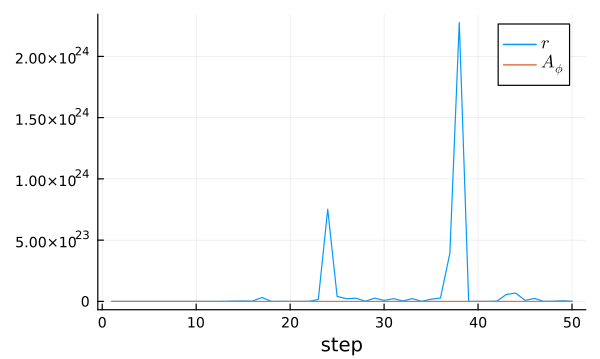

In [14]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191


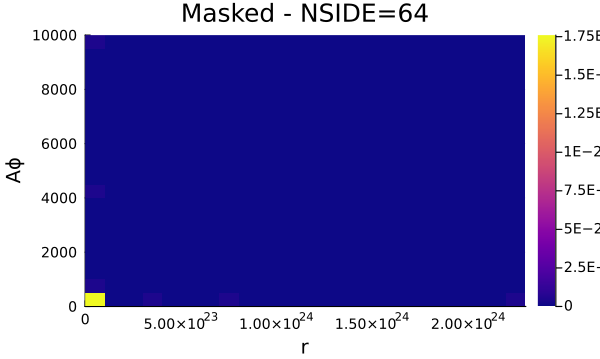

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191


In [15]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

In [ ]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

In [ ]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d];

In [ ]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2);

In [ ]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
plot!(vars, label=string("Parameter space --> K = ", k))

# HMC

In [ ]:
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
ϵ=0.05
samples = 10
@showprogress for i=1:samples
    Ω, = state = hmc_step(rng, prob, init_params, prob.Λmass; symp_kwargs=[(N=25, ϵ=ϵ)], progress=false, always_accept=(i<10))
    push!(samples_hmc, adapt(Array, state))
end
ncalls_hmc = prob.ncalls[]

In [ ]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

In [ ]:
_samples_hmc = zeros(samples, 3*Nside^2+2)
for i in 1:samples
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end
_samples_hmc

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/", Nside, "/HMC/CMBLensing",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
        last_chain = load(string(fol_name, "/", last_chain), "samples")
        init_params = last_chain[:, end]
        println("Restarting chain")
    else
        println("Starting new chain")
        last_n = 0
        init_params = prob.Ωstart
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
    last_n = 0
end

file_name = string(fol_name, "/chain_", last_n+1, "_", samples)

@save file_name _samples_hmc

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/summaries/", Nside,"/HMC/HMC_summary",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", samples)
npzwrite(file_name,
    Dict("r"=> vec(chain_hmc[:r])[:],
    "Aphi"=> vec(chain_hmc[:Aϕ])[:])

In [ ]:
#samples_hmc = load("../chains/HMC/CMBLensing_masked_Nnside_64_ϵ_0.25", "_samples_hmc")

In [ ]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

## Plot

In [ ]:
plot(getindex.(samples_hmc, 2), label=nothing, xlabel="step", ylabel=L"\Delta H")     

In [ ]:
samples_hmc[end][1][:ϕ°][:]

In [ ]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(samples_hmc[end][1][k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)
     


In [ ]:
plot([exp(Ω.θ.r) for (Ω,) in samples_hmc], label=L"r", xlabel="step")
plot!([exp(Ω.θ.Aϕ) for (Ω,) in samples_hmc], label=L"A_\phi")     


In [ ]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

In [ ]:
ess_per_call_hmc = ess_hmc ./ (ncalls_hmc/2)

In [ ]:
ess_per_call_hmc = minimum(ess_hmc ./ (ncalls_hmc/2))

In [ ]:
histogram2d(chain_hmc[:r], chain_hmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!(string("Masked: ", masking, "- NSIDE=", Nside))
ylabel!("Aϕ")
xlabel!("r")

# MUSE

In [ ]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [ ]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [ ]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [ ]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [ ]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

In [ ]:
chain_muse = Chains(permutedims(rand(result.dist,5_000)), [:logr, :logAϕ]);

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/", Nside, "/MUSE/CMBLensing",
    "_cosmo_", global_parameters,
    "_masking_", masking,
    "_Nside_", Nside)
@save fol_name chain_muse

In [ ]:
#chain_muse = load("../chains/MUSE/CMBLensing_masked_Nnside_64", "chain_muse")

In [ ]:
ess_per_call_muse = nsims / ncalls_muse

## Plot

# Compare

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

In [ ]:
ess_per_call_mchmc

In [ ]:
ess_per_call_hmc

In [ ]:
ess_per_call_muse

In [ ]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

In [ ]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)